<div style="text-align: center;">
  <h1>EE 541 – A Computational Introduction to Deep Learning : FALL 2024</h1>
  <h2>CV for American Sign Language Detection</h2>
  <p><em>Badri Narayanan Ramesh, Vivin Thiyagarajan (Group 18)</em></p>
</div>


# Import Statements

In [ ]:

pip install torchsummary


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Importing necessary libraries

# Standard libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
# PyTorch and torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, datasets, models
from torchsummary import summary
import torchvision.transforms as T

# Scikit-learn
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Utilities
from tqdm import tqdm
import shutil
import time

# Data Import

In [ ]:
#Importing data

!pip install kaggle

#Downloading and unzipping the dataset
!kaggle datasets download -d grassknoted/asl-alphabet --unzip

train_dir = './asl_alphabet_train/asl_alphabet_train'
test_dir = './asl_alphabet_test/asl_alphabet_test'


Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
100%|███████████████████████████████████████| 1.03G/1.03G [00:04<00:00, 230MB/s]
100%|███████████████████████████████████████| 1.03G/1.03G [00:04<00:00, 231MB/s]


In [ ]:
#Creating subdirectories for each image in test_dirs:
def organize_test_images(test_dir):
    if not os.path.exists(test_dir):
        print(f"Directory {test_dir} does not exist.")
        return

    for image_file in os.listdir(test_dir):
        if image_file.endswith('.jpg') or image_file.endswith('.jpeg') or image_file.endswith('.png'):
            subdirectory = os.path.join(test_dir, image_file.split('.')[0])
            os.makedirs(subdirectory, exist_ok=True)

            image_path = os.path.join(test_dir, image_file)
            shutil.move(image_path, os.path.join(subdirectory, image_file))
            print(f"Moved {image_file} to {subdirectory}")

test_dir = './asl_alphabet_test/asl_alphabet_test'
organize_test_images(test_dir)

Moved J_test.jpg to ./asl_alphabet_test/asl_alphabet_test/J_test
Moved P_test.jpg to ./asl_alphabet_test/asl_alphabet_test/P_test
Moved Q_test.jpg to ./asl_alphabet_test/asl_alphabet_test/Q_test
Moved F_test.jpg to ./asl_alphabet_test/asl_alphabet_test/F_test
Moved Z_test.jpg to ./asl_alphabet_test/asl_alphabet_test/Z_test
Moved B_test.jpg to ./asl_alphabet_test/asl_alphabet_test/B_test
Moved I_test.jpg to ./asl_alphabet_test/asl_alphabet_test/I_test
Moved U_test.jpg to ./asl_alphabet_test/asl_alphabet_test/U_test
Moved X_test.jpg to ./asl_alphabet_test/asl_alphabet_test/X_test
Moved E_test.jpg to ./asl_alphabet_test/asl_alphabet_test/E_test
Moved L_test.jpg to ./asl_alphabet_test/asl_alphabet_test/L_test
Moved nothing_test.jpg to ./asl_alphabet_test/asl_alphabet_test/nothing_test
Moved M_test.jpg to ./asl_alphabet_test/asl_alphabet_test/M_test
Moved K_test.jpg to ./asl_alphabet_test/asl_alphabet_test/K_test
Moved space_test.jpg to ./asl_alphabet_test/asl_alphabet_test/space_test
Moved

# Defining Utility Functions

In [ ]:
# Setting random seeds for reproducibility
def set_seed(seed=45):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Data Loading and Preprocessing
class DatasetManager:
    def __init__(self, train_dir, test_dir, img_size=200, batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size

        # Initializing transformations
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

        # Load the training dataset
        self.train_dataset = datasets.ImageFolder(root=train_dir, transform=self.transform)
        self.class_names = self.train_dataset.classes
        self.num_classes = len(self.class_names)

        # Calculate mean and std using the training dataset
        self.mean, self.std = self.calculate_mean_std(self.train_dataset)

        # Applying normalization with the calculated mean and std
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean, std=self.std),
        ])

        # Re-loading the dataset with the new normalization transform
        self.train_dataset = datasets.ImageFolder(root=train_dir, transform=self.transform)

        # Splitting the dataset into train and validation
        indices = torch.randperm(len(self.train_dataset)).tolist()
        train_size = int(0.8 * len(self.train_dataset))
        val_size = len(self.train_dataset) - train_size
        train_indices, val_indices = indices[:train_size], indices[train_size:]

        self.train_dataset = torch.utils.data.Subset(self.train_dataset, train_indices)
        self.val_dataset = torch.utils.data.Subset(
            datasets.ImageFolder(root=train_dir, transform=self.transform),
            val_indices
        )

        self.test_dataset = datasets.ImageFolder(root=test_dir, transform=self.transform)

        # Creating dataloaders
        self.train_loader = DataLoader(
            self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
        )
        self.val_loader = DataLoader(
            self.val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
        )
        self.test_loader = DataLoader(
            self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
        )

    def calculate_mean_std(self, dataset):

        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)
        mean = 0.0
        std = 0.0
        total_images = 0

        for images, _ in loader:
            batch_samples = images.size(0)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)
            total_images += batch_samples

        mean /= total_images
        std /= total_images

        return mean.tolist(), std.tolist()



# Basic CNN Implementation
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, use_regularization=False):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32) if use_regularization else nn.Identity(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64) if use_regularization else nn.Identity(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128) if use_regularization else nn.Identity(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 25 * 25, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training and Evaluation Functions

class ModelTrainer:
    def __init__(self, model, device, criterion, optimizer):
        self.model = model
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_history = {
            "train_loss": [],
            "train_accuracy": [],
            "val_loss": [],
            "val_accuracy": []
        }

    def train(self, train_loader, val_loader, epochs, save_path):
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            train_loss, train_accuracy = self._train_one_epoch(train_loader)
            val_loss, val_accuracy = self._validate(val_loader)

            self.training_history["train_loss"].append(train_loss)
            self.training_history["train_accuracy"].append(train_accuracy)
            self.training_history["val_loss"].append(val_loss)
            self.training_history["val_accuracy"].append(val_accuracy)

            print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
            print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

        torch.save(self.model.state_dict(), save_path)

    def _train_one_epoch(self, loader):
        self.model.train()
        running_loss = 0
        correct_predictions = 0
        total_samples = 0

        for images, labels in loader:
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

        avg_loss = running_loss / len(loader)
        accuracy = 100.0 * correct_predictions / total_samples
        return avg_loss, accuracy

    def _validate(self, loader):
        self.model.eval()
        running_loss = 0
        correct_predictions = 0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels).item()

        avg_loss = running_loss / len(loader)
        accuracy = 100.0 * correct_predictions / len(loader.dataset)
        return avg_loss, accuracy

    def plot_training_history(self):
        epochs = range(1, len(self.training_history["train_loss"]) + 1)

        plt.figure(figsize=(12, 7))

        # Loss Plot
        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.training_history["train_loss"], label="Train Loss")
        plt.plot(epochs, self.training_history["val_loss"], label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()

        # Accuracy Plot
        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.training_history["train_accuracy"], label="Train Accuracy")
        plt.plot(epochs, self.training_history["val_accuracy"], label="Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy (%)")
        plt.title("Training and Validation Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()
    def predict(self, loader):
        self.model.eval()
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for images, labels in loader:
                images = images.to(self.device)
                outputs = self.model(images)
                _, preds = torch.max(outputs, 1)
                all_predictions.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        return np.array(all_predictions), np.array(all_labels)

# Pre-trained Models Training
class PretrainedModelHandler:
    @staticmethod
    def get_model(model_name, num_classes, freeze_features=True, use_regularization=False):
        if model_name == "vgg16":
            model = models.vgg16(pretrained=True)
            if freeze_features:
                for param in model.features.parameters():
                    param.requires_grad = False
            num_features = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(num_features, num_classes)

        elif model_name == "resnet50":
            model = models.resnet50(pretrained=True)
            if freeze_features:
                for param in model.parameters():
                    param.requires_grad = False
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, num_classes)

        elif model_name == "googlenet":
            model = models.googlenet(pretrained=True)
            if freeze_features:
                for param in model.parameters():
                    param.requires_grad = False
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, num_classes)

        elif model_name == "mobilenet":
            model = models.mobilenet_v2(pretrained=True)
            if freeze_features:
                for param in model.parameters():
                    param.requires_grad = False
            num_features = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(num_features, num_classes)

        if use_regularization:
            # Adding dropout layers before classification layers
            if model_name == "vgg16":
                model.classifier[5] = nn.Sequential(
                    nn.Dropout(0.5),
                    model.classifier[5]
                )
            elif model_name in ["resnet50", "googlenet", "mobilenet"]:
                model.fc = nn.Sequential(
                    nn.Dropout(0.5),
                    model.fc
                )

        return model

# Visualization function
class ResultsVisualizer:
    def __init__(self):
        self.results = []

    def add_result(self, model_name, accuracy, precision, recall, f1_score, model_size, inference_speed):
        self.results.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1_score,
            "Model Size (MB)": model_size,
            "Inference Speed (s)": inference_speed
        })

    def plot_comparison(self):

        df = pd.DataFrame(self.results)

        # Bar plot for Accuracy, Precision, Recall, F1-Score
        metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

        plt.figure(figsize=(15, 8))
        bar_width = 0.2
        index = np.arange(len(df["Model"]))

        for i, metric in enumerate(metrics):
            plt.bar(index + i * bar_width, df[metric], bar_width, label=f"{metric} (%)")

        plt.xlabel("Models")
        plt.ylabel("Score (%)")
        plt.title("Model Performance Comparison")
        plt.xticks(index + bar_width * 1.5, df["Model"], rotation=45, ha="right")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plotting Model Size and Inference Speed
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Bar plot for Model Size
        ax1.bar(df["Model"], df["Model Size (MB)"], color="lightgreen")
        ax1.set_title("Model Size Comparison (MB)")
        ax1.set_xlabel("Model")
        ax1.set_ylabel("Size (MB)")
        ax1.tick_params(axis="x", rotation=45)

        # Bar plot for Inference Speed
        ax2.bar(df["Model"], df["Inference Speed (s)"], color="salmon")
        ax2.set_title("Inference Speed Comparison (Seconds)")
        ax2.set_xlabel("Model")
        ax2.set_ylabel("Speed (s)")
        ax2.tick_params(axis="x", rotation=45)

        plt.tight_layout()
        plt.show()

    def generate_table(self):

        df = pd.DataFrame(self.results)
        df = df.sort_values(by="Accuracy", ascending=False)  # Sortting by Accuracy for better comparison

        styled_table = df.style.set_table_styles(
            [{
                'selector': 'thead th',
                'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold')]
            }, {
                'selector': 'tbody td',
                'props': [('border', '1px solid black'), ('padding', '5px')]
            }])

        return df, styled_table

def measure_inference_speed(model, data_loader, device):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            model(inputs)
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / len(data_loader)  # average time per batch
    return avg_inference_time

def get_model_size(model):

    model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024 * 1024)
    return model_size

# Model Training


Training cnn_no_reg
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
              ReLU-2         [-1, 32, 200, 200]               0
          Identity-3         [-1, 32, 200, 200]               0
         MaxPool2d-4         [-1, 32, 100, 100]               0
            Conv2d-5         [-1, 64, 100, 100]          18,496
              ReLU-6         [-1, 64, 100, 100]               0
          Identity-7         [-1, 64, 100, 100]               0
         MaxPool2d-8           [-1, 64, 50, 50]               0
            Conv2d-9          [-1, 128, 50, 50]          73,856
             ReLU-10          [-1, 128, 50, 50]               0
         Identity-11          [-1, 128, 50, 50]               0
        MaxPool2d-12          [-1, 128, 25, 25]               0
          Flatten-13                [-1, 80000]               0
           Linear-

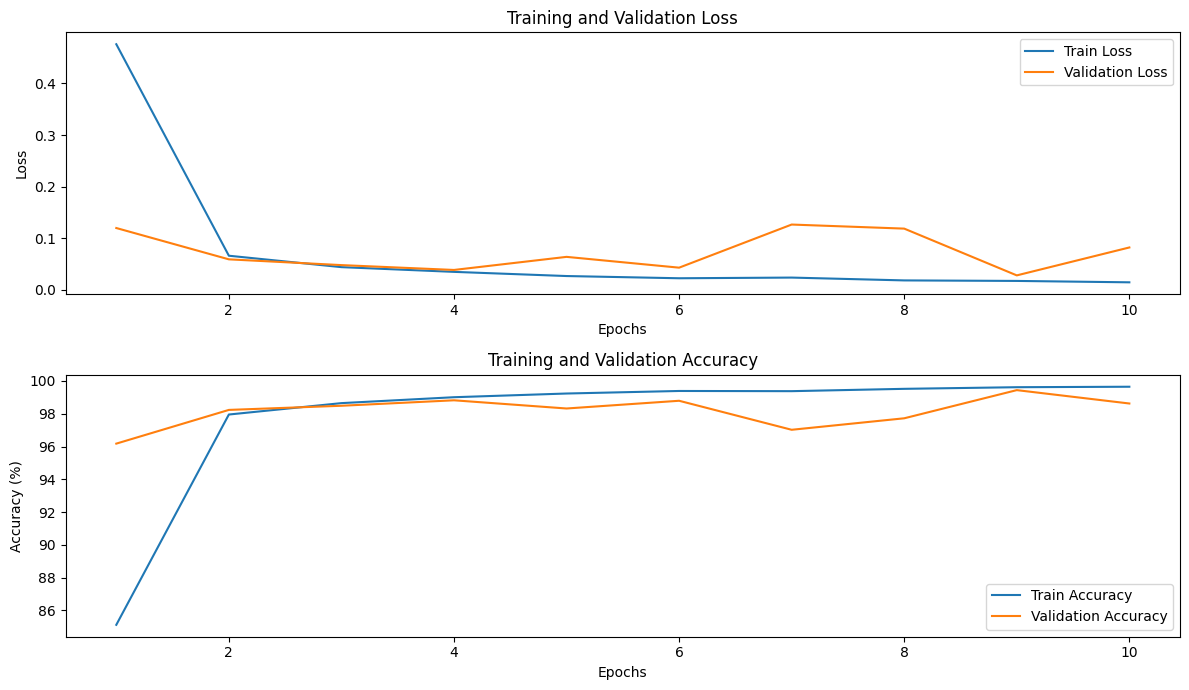


Training cnn_with_reg
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
              ReLU-2         [-1, 32, 200, 200]               0
       BatchNorm2d-3         [-1, 32, 200, 200]              64
         MaxPool2d-4         [-1, 32, 100, 100]               0
            Conv2d-5         [-1, 64, 100, 100]          18,496
              ReLU-6         [-1, 64, 100, 100]               0
       BatchNorm2d-7         [-1, 64, 100, 100]             128
         MaxPool2d-8           [-1, 64, 50, 50]               0
            Conv2d-9          [-1, 128, 50, 50]          73,856
             ReLU-10          [-1, 128, 50, 50]               0
      BatchNorm2d-11          [-1, 128, 50, 50]             256
        MaxPool2d-12          [-1, 128, 25, 25]               0
          Flatten-13                [-1, 80000]               0
           Linea

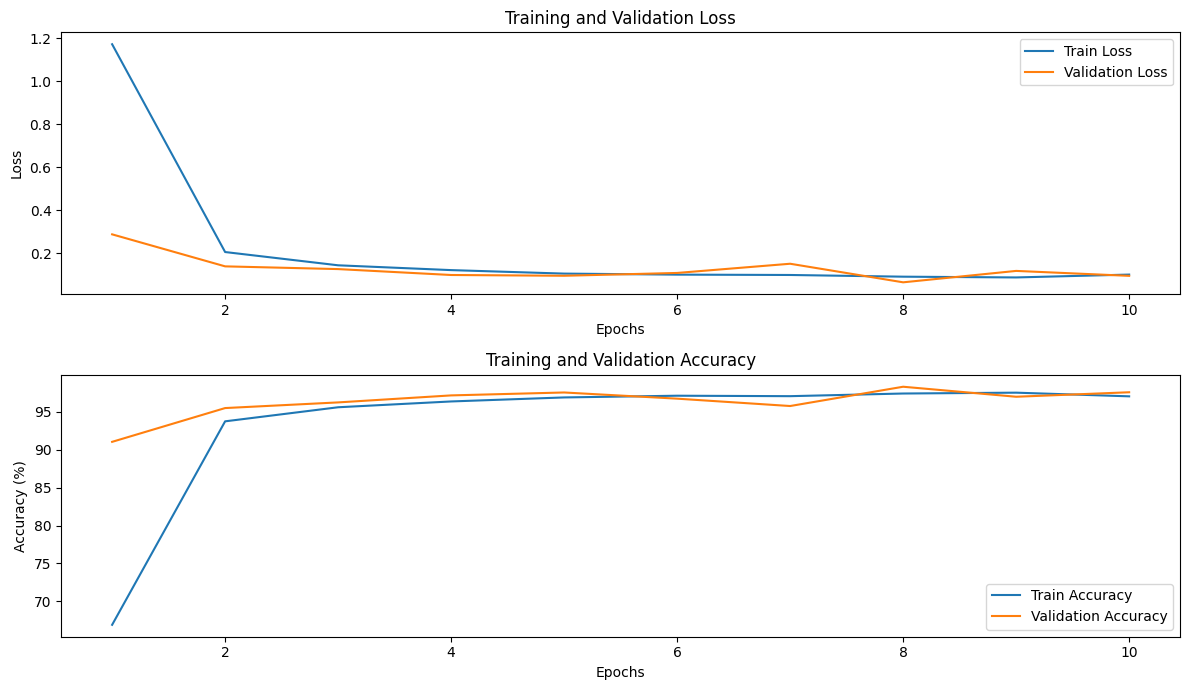


Training vgg16_frozen_no_reg


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 208MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           1,792
              ReLU-2         [-1, 64, 200, 200]               0
            Conv2d-3         [-1, 64, 200, 200]          36,928
              ReLU-4         [-1, 64, 200, 200]               0
         MaxPool2d-5         [-1, 64, 100, 100]               0
            Conv2d-6        [-1, 128, 100, 100]          73,856
              ReLU-7        [-1, 128, 100, 100]               0
            Conv2d-8        [-1, 128, 100, 100]         147,584
              ReLU-9        [-1, 128, 100, 100]               0
        MaxPool2d-10          [-1, 128, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]         295,168
             ReLU-12          [-1, 256, 50, 50]               0
           Conv2d-13          [-1, 256, 50, 50]         590,080
             ReLU-14          [-1, 256,

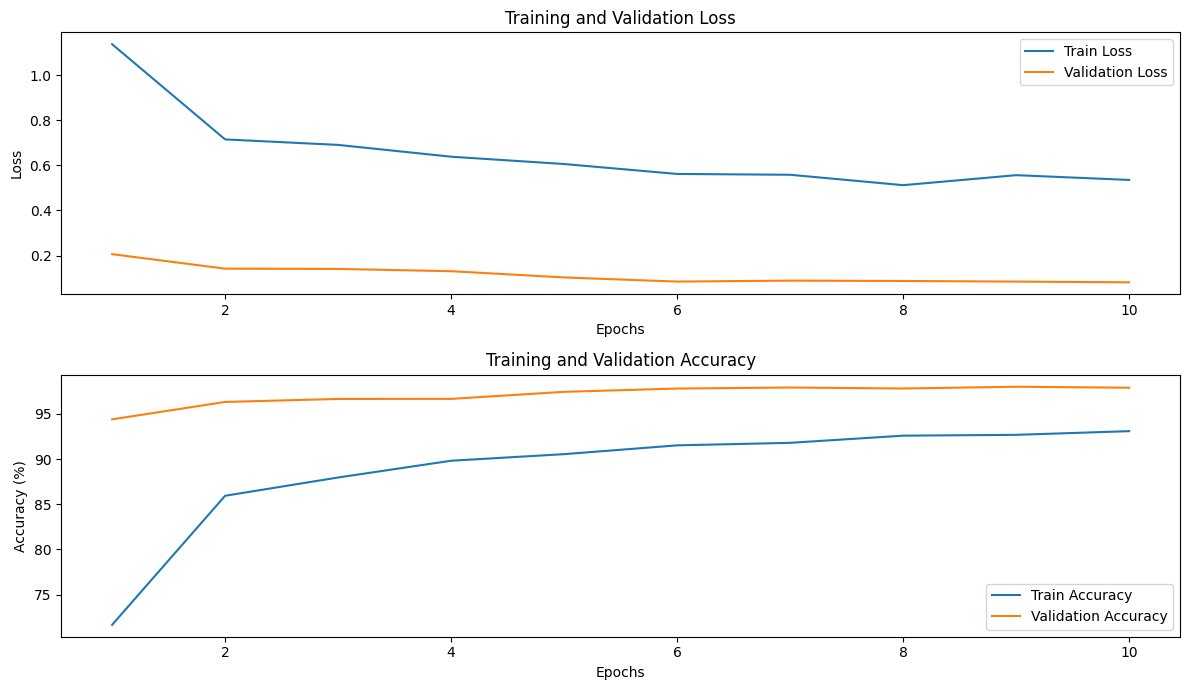


Training vgg16_frozen_l2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           1,792
              ReLU-2         [-1, 64, 200, 200]               0
            Conv2d-3         [-1, 64, 200, 200]          36,928
              ReLU-4         [-1, 64, 200, 200]               0
         MaxPool2d-5         [-1, 64, 100, 100]               0
            Conv2d-6        [-1, 128, 100, 100]          73,856
              ReLU-7        [-1, 128, 100, 100]               0
            Conv2d-8        [-1, 128, 100, 100]         147,584
              ReLU-9        [-1, 128, 100, 100]               0
        MaxPool2d-10          [-1, 128, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]         295,168
             ReLU-12          [-1, 256, 50, 50]               0
           Conv2d-13          [-1, 256, 50, 50]         590,080
             

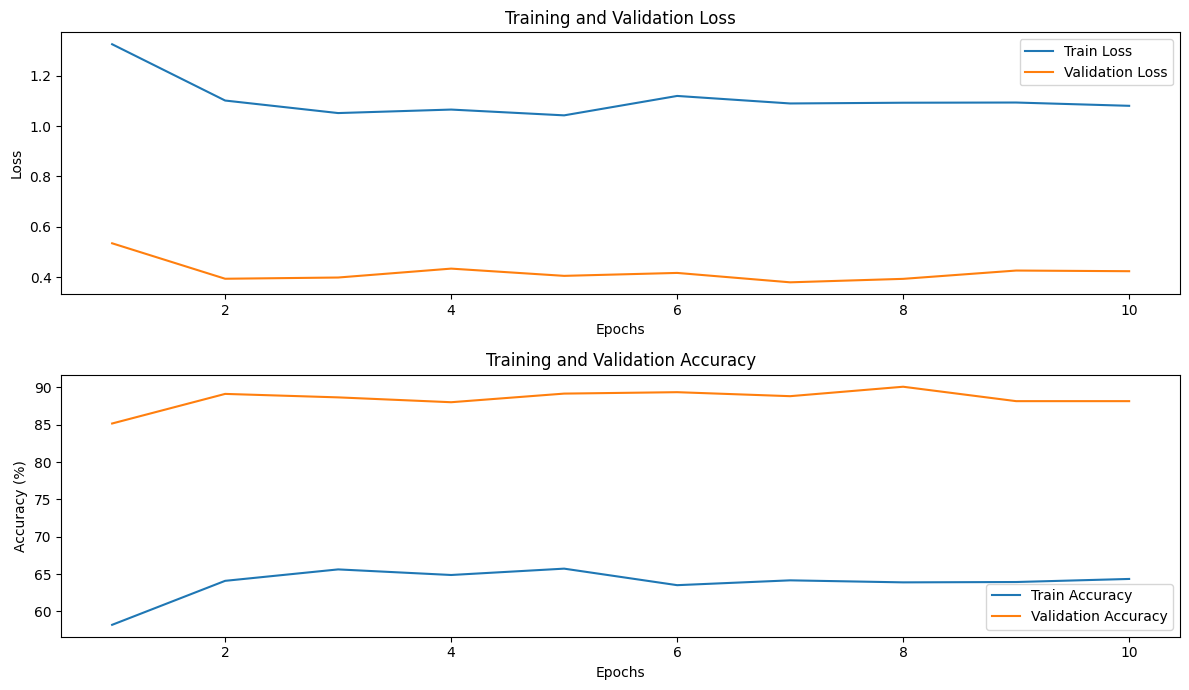


Training resnet50_frozen_no_reg


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]           4,096
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]          16,384
      BatchNorm2d-12          [-1, 256, 50, 50]             512
           Conv2d-13          [-1, 256, 50, 50]          16,384
      BatchNorm2d-14          [-1, 256,

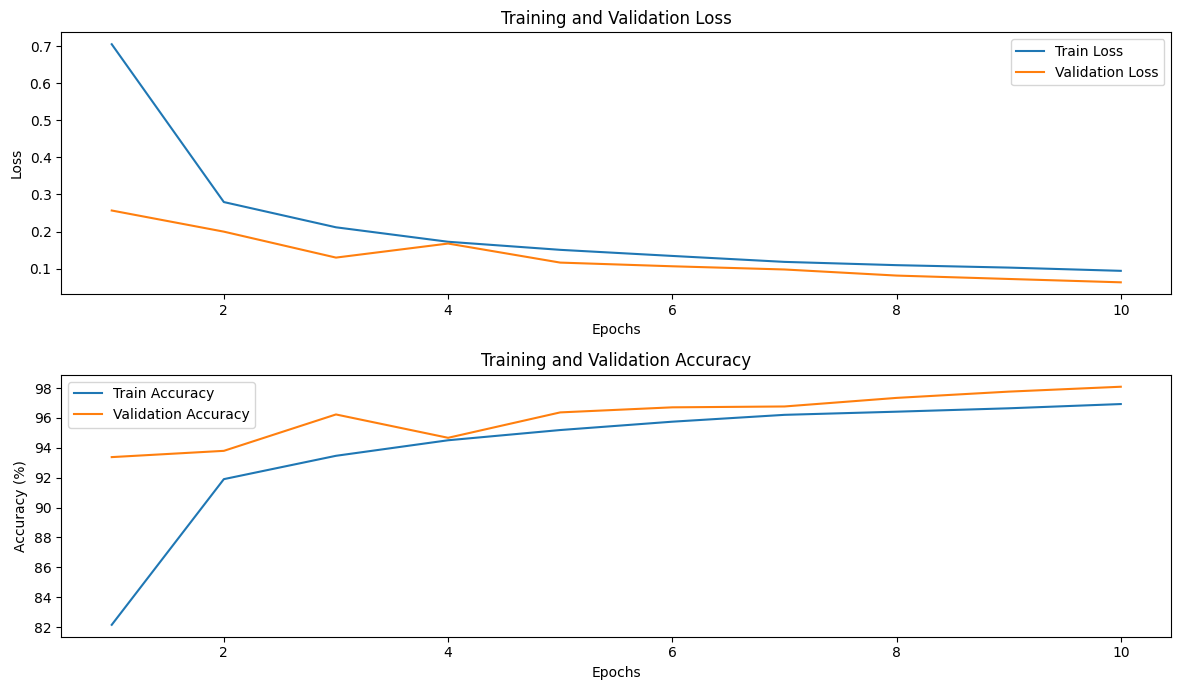


Training resnet50_frozen_l2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]           4,096
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]          16,384
      BatchNorm2d-12          [-1, 256, 50, 50]             512
           Conv2d-13          [-1, 256, 50, 50]          16,384
      Batc

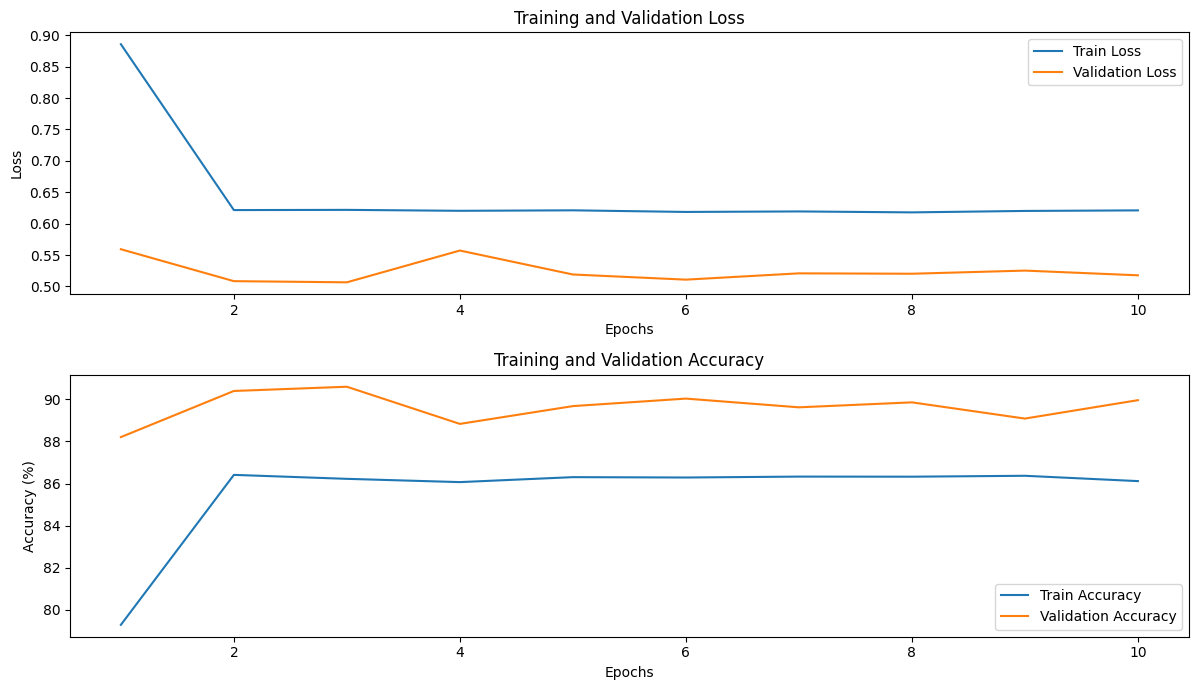


Training googlenet_frozen_no_reg


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 181MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
       BasicConv2d-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]           4,096
       BatchNorm2d-6           [-1, 64, 50, 50]             128
       BasicConv2d-7           [-1, 64, 50, 50]               0
            Conv2d-8          [-1, 192, 50, 50]         110,592
       BatchNorm2d-9          [-1, 192, 50, 50]             384
      BasicConv2d-10          [-1, 192, 50, 50]               0
        MaxPool2d-11          [-1, 192, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          12,288
      BatchNorm2d-13           [-1, 64, 25, 25]             128
      BasicConv2d-14           [-1, 64,

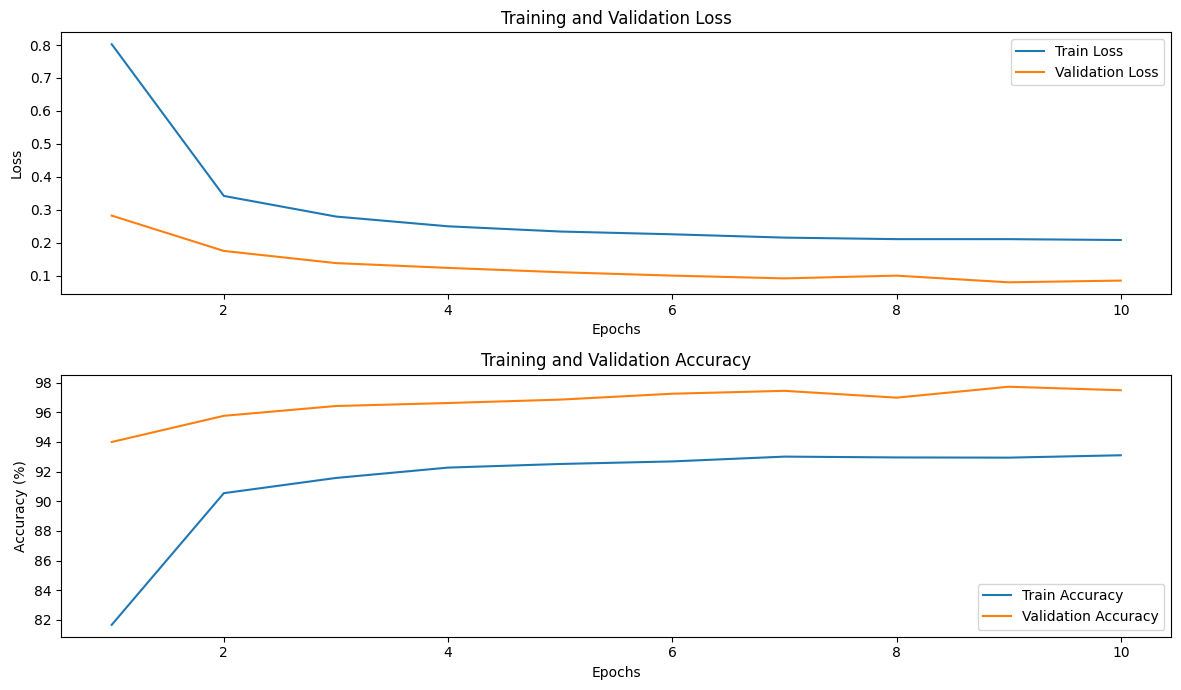


Training googlenet_frozen_l2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
       BasicConv2d-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]           4,096
       BatchNorm2d-6           [-1, 64, 50, 50]             128
       BasicConv2d-7           [-1, 64, 50, 50]               0
            Conv2d-8          [-1, 192, 50, 50]         110,592
       BatchNorm2d-9          [-1, 192, 50, 50]             384
      BasicConv2d-10          [-1, 192, 50, 50]               0
        MaxPool2d-11          [-1, 192, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          12,288
      BatchNorm2d-13           [-1, 64, 25, 25]             128
      Bas

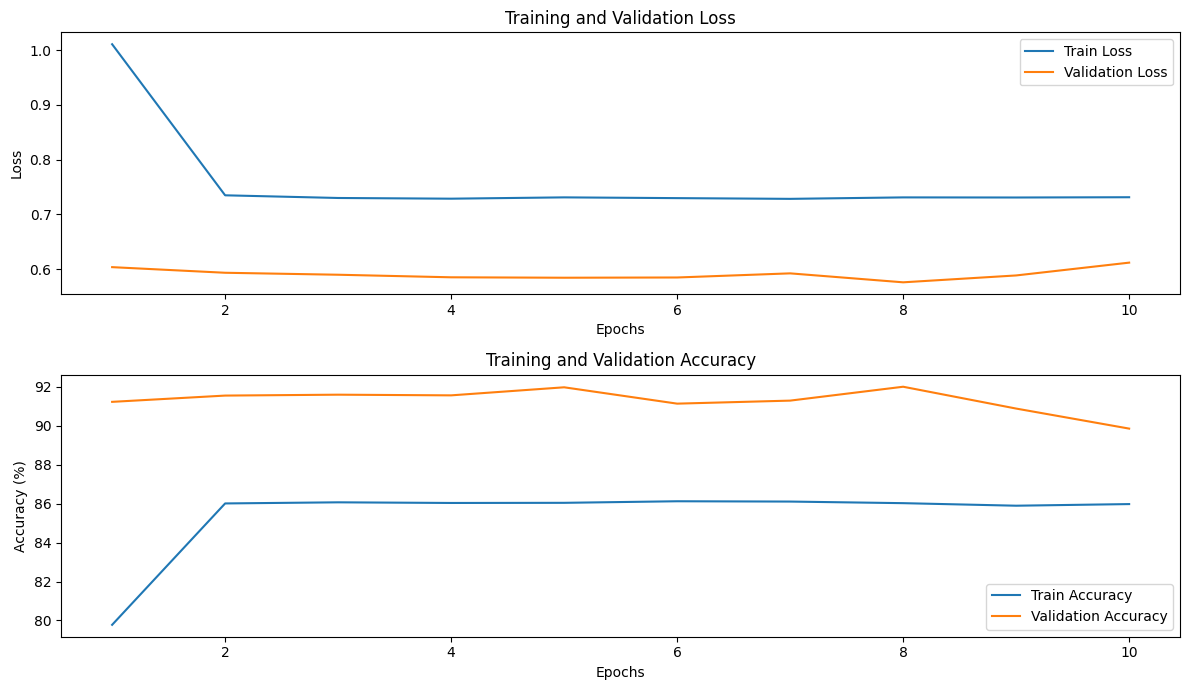

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Training mobilenet_frozen_no_reg


100%|██████████| 13.6M/13.6M [00:00<00:00, 127MB/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             864
       BatchNorm2d-2         [-1, 32, 100, 100]              64
             ReLU6-3         [-1, 32, 100, 100]               0
            Conv2d-4         [-1, 32, 100, 100]             288
       BatchNorm2d-5         [-1, 32, 100, 100]              64
             ReLU6-6         [-1, 32, 100, 100]               0
            Conv2d-7         [-1, 16, 100, 100]             512
       BatchNorm2d-8         [-1, 16, 100, 100]              32
  InvertedResidual-9         [-1, 16, 100, 100]               0
           Conv2d-10         [-1, 96, 100, 100]           1,536
      BatchNorm2d-11         [-1, 96, 100, 100]             192
            ReLU6-12         [-1, 96, 100, 100]               0
           Conv2d-13           [-1, 96, 50, 50]             864
      BatchNorm2d-14           [-1, 96,

Train Loss: 0.6366 | Train Accuracy: 84.38%
Val Loss: 0.1949 | Val Accuracy: 95.61%
Epoch 2/10
Train Loss: 0.2701 | Train Accuracy: 91.89%
Val Loss: 0.1383 | Val Accuracy: 96.26%
Epoch 3/10
Train Loss: 0.2237 | Train Accuracy: 92.85%
Val Loss: 0.1029 | Val Accuracy: 97.13%
Epoch 4/10
Train Loss: 0.2044 | Train Accuracy: 93.25%
Val Loss: 0.0918 | Val Accuracy: 97.18%
Epoch 5/10
Train Loss: 0.1895 | Train Accuracy: 93.71%
Val Loss: 0.0736 | Val Accuracy: 97.97%
Epoch 6/10
Train Loss: 0.1879 | Train Accuracy: 93.63%
Val Loss: 0.0797 | Val Accuracy: 97.43%
Epoch 7/10
Train Loss: 0.1816 | Train Accuracy: 93.84%
Val Loss: 0.0688 | Val Accuracy: 97.93%
Epoch 8/10
Train Loss: 0.1755 | Train Accuracy: 94.01%
Val Loss: 0.0640 | Val Accuracy: 97.97%
Epoch 9/10
Train Loss: 0.1769 | Train Accuracy: 93.97%
Val Loss: 0.0612 | Val Accuracy: 98.01%
Epoch 10/10
Train Loss: 0.1738 | Train Accuracy: 94.11%
Val Loss: 0.0609 | Val Accuracy: 98.08%


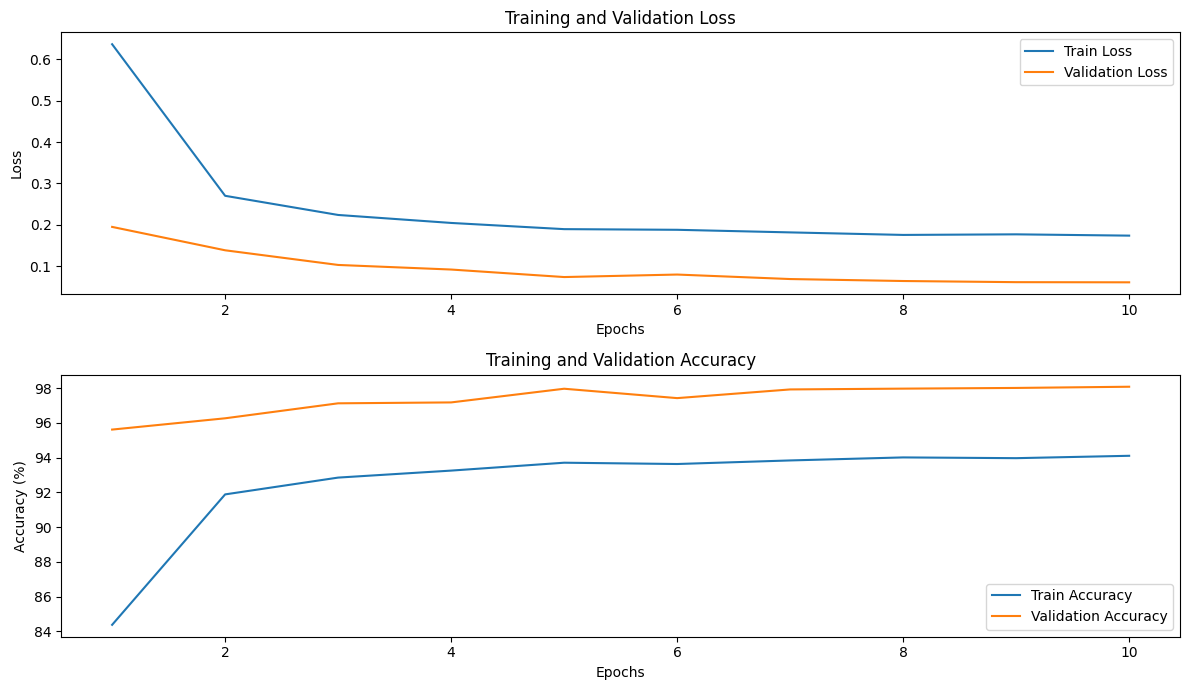


Training mobilenet_frozen_l2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             864
       BatchNorm2d-2         [-1, 32, 100, 100]              64
             ReLU6-3         [-1, 32, 100, 100]               0
            Conv2d-4         [-1, 32, 100, 100]             288
       BatchNorm2d-5         [-1, 32, 100, 100]              64
             ReLU6-6         [-1, 32, 100, 100]               0
            Conv2d-7         [-1, 16, 100, 100]             512
       BatchNorm2d-8         [-1, 16, 100, 100]              32
  InvertedResidual-9         [-1, 16, 100, 100]               0
           Conv2d-10         [-1, 96, 100, 100]           1,536
      BatchNorm2d-11         [-1, 96, 100, 100]             192
            ReLU6-12         [-1, 96, 100, 100]               0
           Conv2d-13           [-1, 96, 50, 50]             864
      Bat

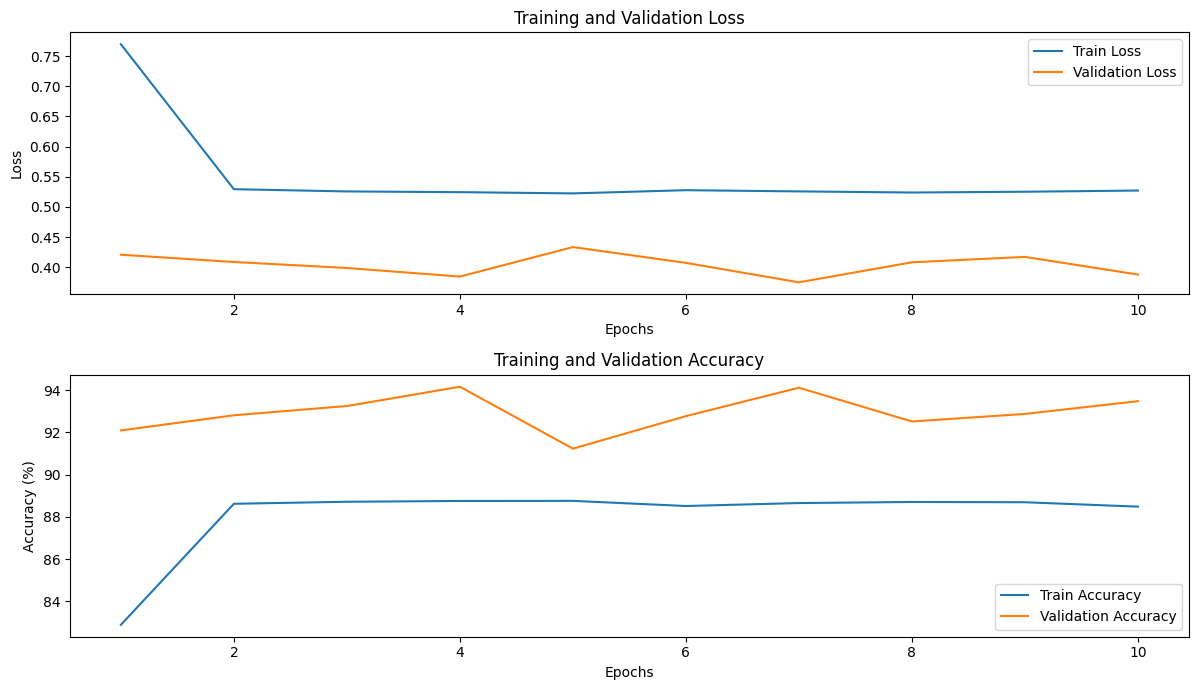

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = './asl_alphabet_train/asl_alphabet_train'
test_dir = './asl_alphabet_test/asl_alphabet_test'
data_manager = DatasetManager(train_dir, test_dir)
# Training Custom CNN Models
cnn_variations = [
    ("cnn_no_reg", False),  # No regularization
    ("cnn_with_reg", True)  # With L2 regularization
]

for variation_name, use_reg in cnn_variations:
    print(f"\nTraining {variation_name}")
    weight_decay = 0.01 if use_reg else 0
    cnn_model = SimpleCNN(num_classes=data_manager.num_classes, use_regularization=use_reg).to(device)
    print(summary(cnn_model, (3, 200, 200)))
    cnn_trainer = ModelTrainer(
        model=cnn_model,
        device=device,
        criterion=nn.CrossEntropyLoss(),
        optimizer=optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=weight_decay)
    )
    cnn_trainer.train(
        train_loader=data_manager.train_loader,
        val_loader=data_manager.val_loader,
        epochs=10,
        save_path=f"{variation_name}_weights.pth"
    )
    cnn_trainer.plot_training_history()
# Training Pre-trained Models
pretrained_models = ["vgg16", "resnet50", "googlenet", "mobilenet"]
configurations = [
    ("frozen_no_reg", True, 0),   # No regularization
    ("frozen_l2", True, 0.01), # L2 regularization

]

for model_name in pretrained_models:
    for config_name, freeze, weight_decay in configurations:
        full_name = f"{model_name}_{config_name}"
        print(f"\nTraining {full_name}")
        model = PretrainedModelHandler.get_model(
            model_name=model_name,
            num_classes=data_manager.num_classes,
            freeze_features=freeze
        ).to(device)
        print(summary(model, (3, 200, 200)))
        trainer = ModelTrainer(
            model=model,
            device=device,
            criterion=nn.CrossEntropyLoss(),
            optimizer=optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
        )
        trainer.train(
            train_loader=data_manager.train_loader,
            val_loader=data_manager.val_loader,
            epochs=10,
            save_path=f"{full_name}_weights.pth"
        )
        trainer.plot_training_history()





# Training Dinov2+ SVM

In [ ]:
# CustomDataset Class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

transform = T.Compose([
    T.Resize((224, 224)),  # Resizing to 224x224 for DINOv2 model
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

def get_image_paths_and_labels(root_dir):
    image_paths = []
    labels = []
    for label, class_name in enumerate(os.listdir(root_dir)):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                image_paths.append(img_path)
                labels.append(label)
    return image_paths, labels


all_image_paths, all_labels = get_image_paths_and_labels(train_dir)

# Increasing test sample size to 20% of the total dataset
train_val_image_paths, test_image_paths, train_val_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42
)

# Splitttng the remaining data into training and validation (80-20 split of train_val set)
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    train_val_image_paths, train_val_labels, test_size=0.2, random_state=42
)

train_dataset1 = CustomDataset(image_paths=train_image_paths, labels=train_labels, transform=transform)
val_dataset1 = CustomDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)
test_dataset1 = CustomDataset(image_paths=test_image_paths, labels=test_labels, transform=transform)

train_loader1 = DataLoader(train_dataset1, batch_size=32, shuffle=True, num_workers=2)
val_loader1 = DataLoader(val_dataset1, batch_size=32, shuffle=False, num_workers=2)
test_loader1 = DataLoader(test_dataset1, batch_size=32, shuffle=False, num_workers=2)

# Print dataset statistics
print(f"Train samples: {len(train_dataset1)}")
print(f"Validation samples: {len(val_dataset1)}")
print(f"Test samples: {len(test_dataset1)}")

Train samples: 55680
Validation samples: 13920
Test samples: 17400


In [ ]:
print(set(train_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}


In [ ]:
print(set(test_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}


[24 27 24 ...  7 14 17]


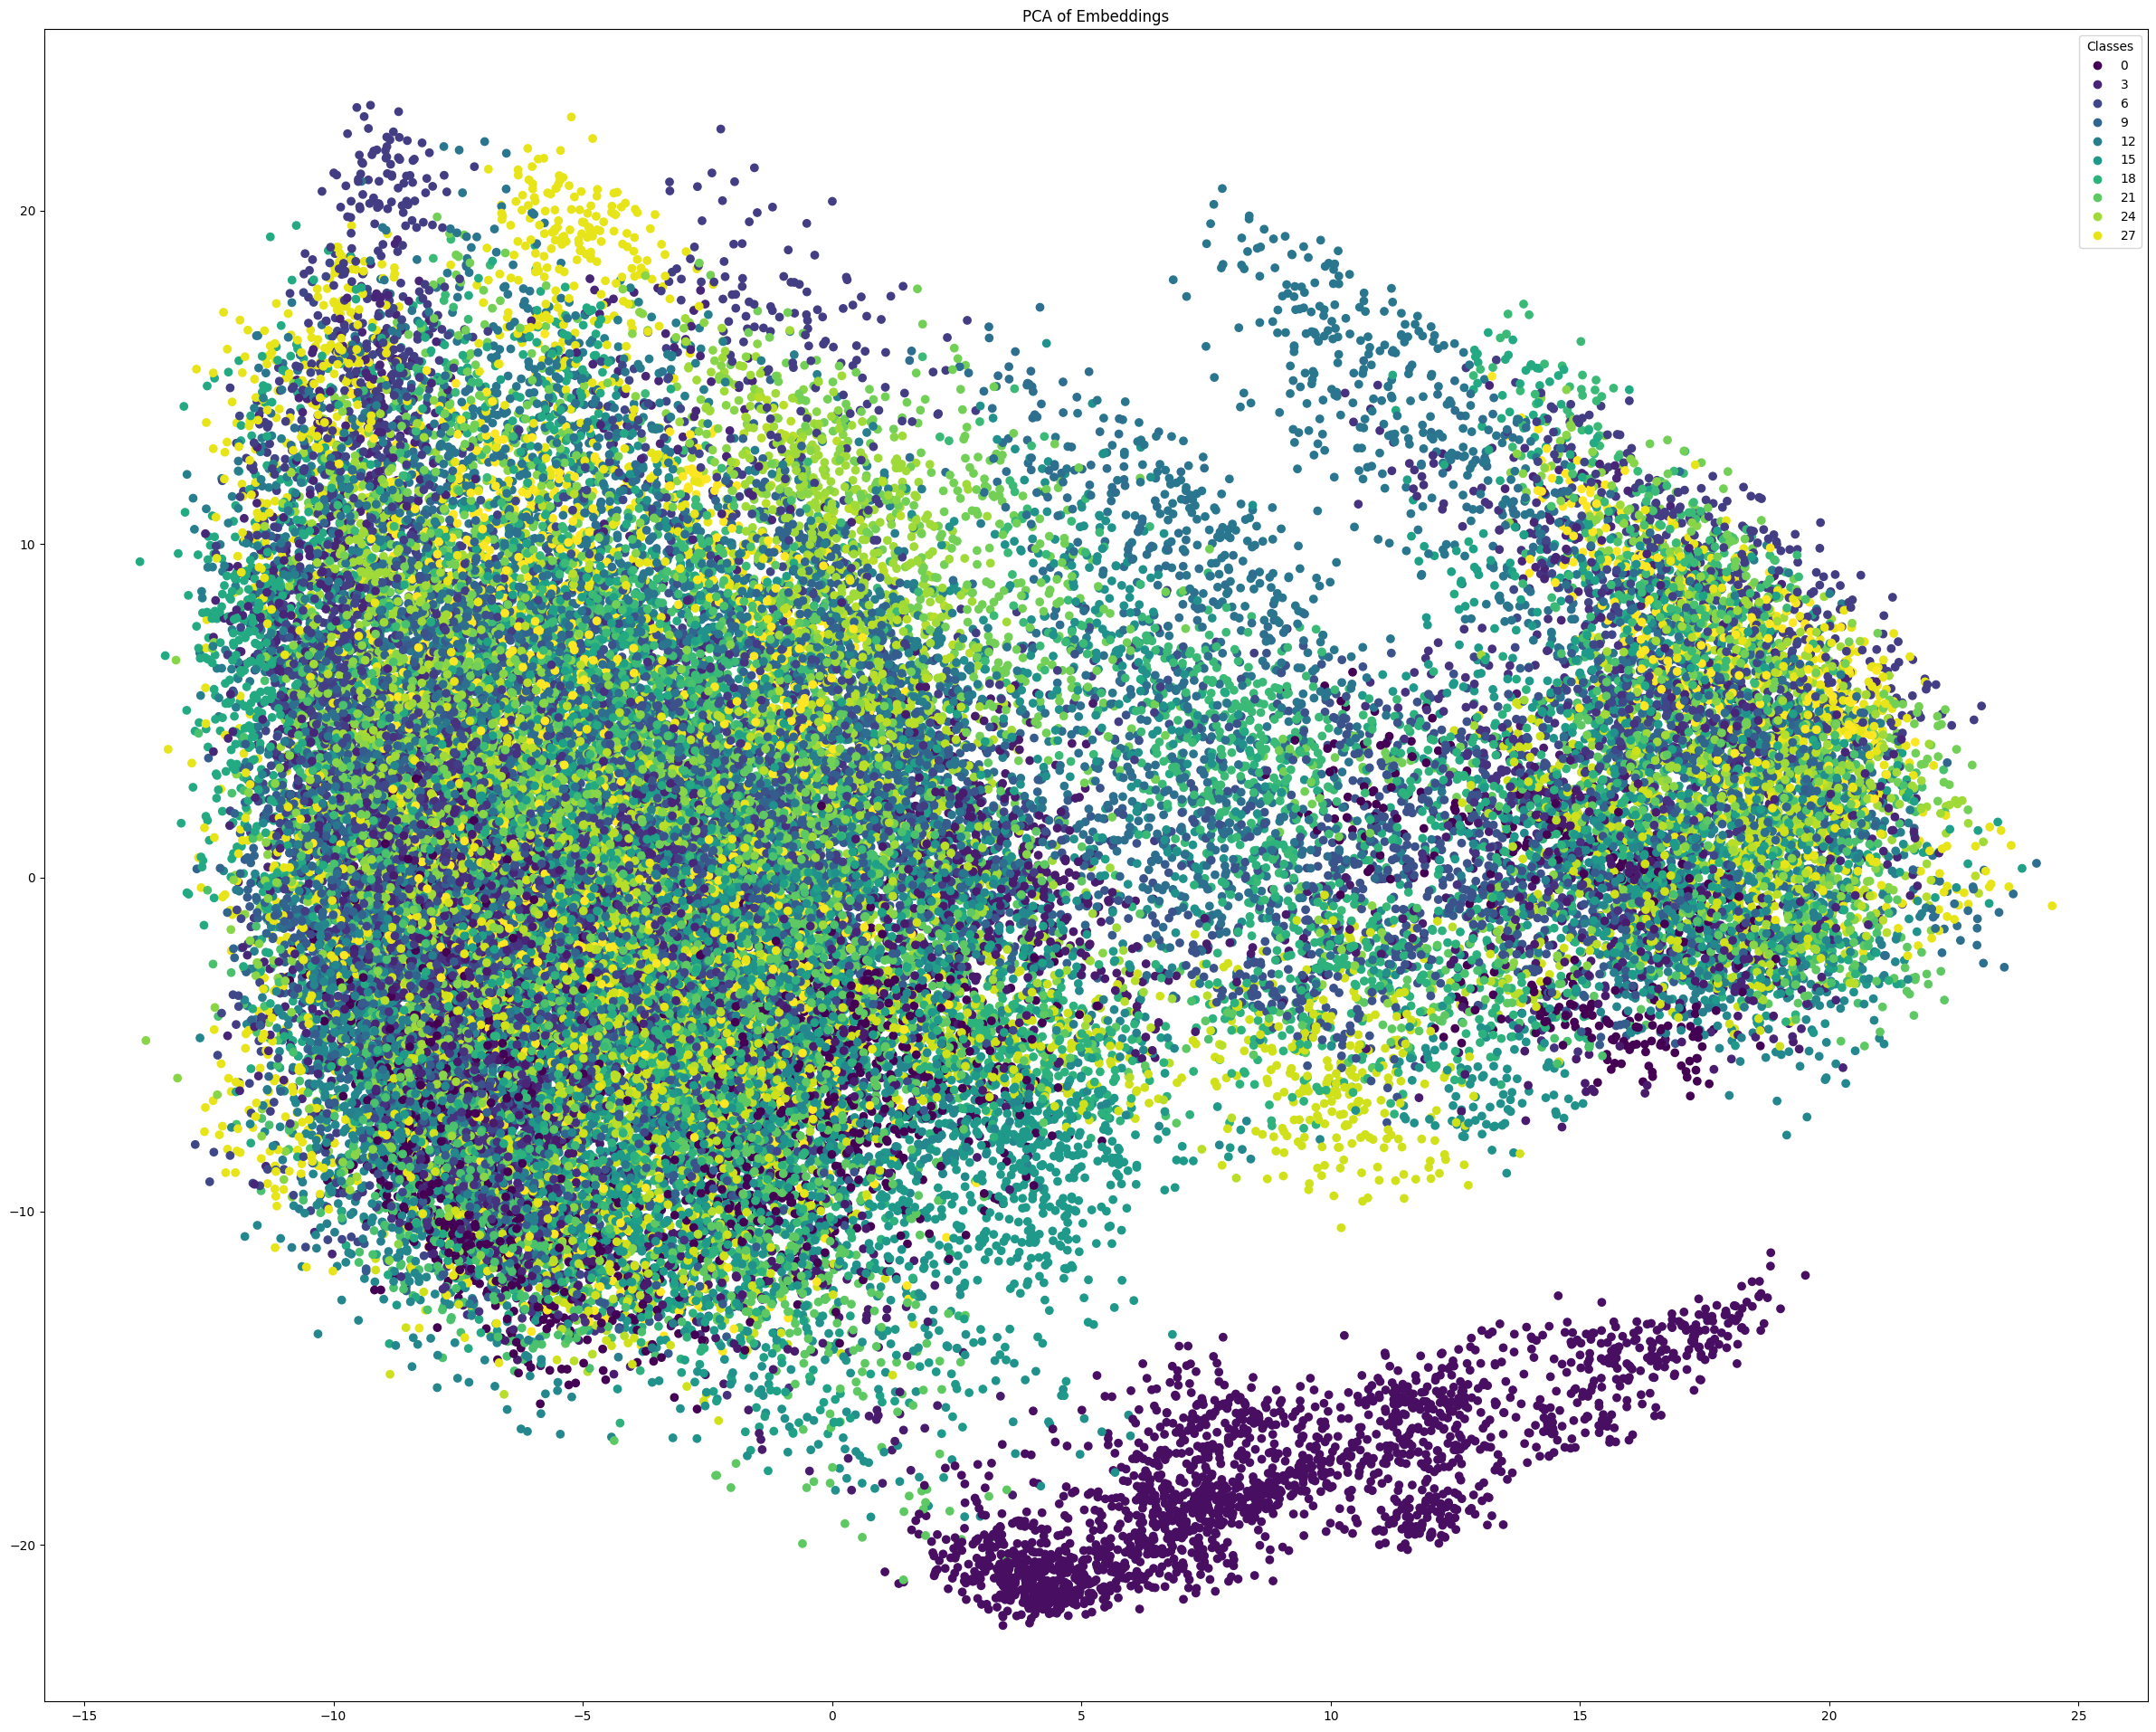

In [ ]:
#Visualizing the embeddings

pca = PCA(n_components=6)
reduced_embeddings = pca.fit_transform(train_embeddings)

# Creating the scatter plot
plt.figure(figsize=(30, 24))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=train_labels, cmap='viridis')

plt.title("PCA of Embeddings")
print(train_labels)
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, title="Classes")
plt.show()


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Computing Embeddings: 100%|██████████| 544/544 [01:44<00:00,  5.19it/s]


Train Labels:  [22  2 25 ... 16  2 20]
Test Labels:  [19  9 11 ... 24 16 16]
DINOv2 + SVM Validation Accuracy: 99.91%
Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       495
           1       1.00      1.00      1.00       509
           2       1.00      1.00      1.00       458
           3       1.00      1.00      1.00       500
           4       1.00      1.00      1.00       480
           5       1.00      1.00      1.00       498
           6       1.00      1.00      1.00       470
           7       1.00      1.00      1.00       477
           8       1.00      1.00      1.00       477
           9       0.99      1.00      1.00       516
          10       1.00      1.00      1.00       495
          11       1.00      1.00      1.00       469
          12       1.00      1.00      1.00       460
          13       1.00      1.00      1.00       457
          14       1.00      1.00   

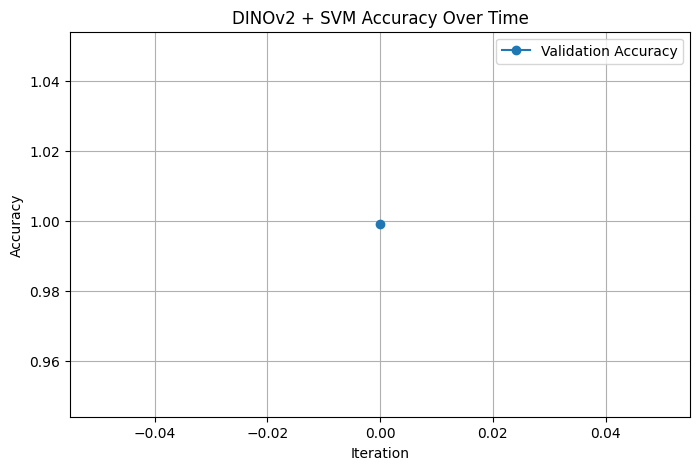

In [ ]:

#  DINO + SVM evaluation
class DINOv2Handler:
    def __init__(self, device, img_size=224):
        self.device = device
        self.model = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)

        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize([0.5], [0.5])
        ])

    def load_image(self, img_path):
        img = Image.open(img_path)
        transformed_img = self.transform(img).unsqueeze(0)
        return transformed_img

    def compute_embeddings(self, data_loader):

        embeddings, labels = [], []
        self.model.eval()

        with torch.no_grad():
            for images, targets in tqdm(data_loader, desc="Computing Embeddings"):
                images = images.to(self.device)
                targets = targets.to(self.device)

                # Extracting features using the DINOv2 model
                features = self.model(images)

                embeddings.append(features.cpu().numpy())
                labels.extend(targets.cpu().numpy())

        return np.vstack(embeddings), np.array(labels)

# SVM Trainer for DINOv2 embeddings
class SVMTrainer:
    def __init__(self, kernel="linear", C=1.0):
        self.svm = SVC(kernel=kernel, C=C)
        self.train_accuracy_history = []
        self.val_accuracy_history = []

    def train(self, train_embeddings, train_labels, val_embeddings=None, val_labels=None):
        self.svm.fit(train_embeddings, train_labels)
        if val_embeddings is not None and val_labels is not None:
            self.evaluate(val_embeddings, val_labels, log_metrics=True)

    def evaluate(self, test_embeddings, test_labels, target_names=None, log_metrics=False):
        predictions = self.svm.predict(test_embeddings)
        accuracy = accuracy_score(test_labels, predictions)
        if log_metrics:
            self.val_accuracy_history.append(accuracy)
        report = classification_report(test_labels, predictions, target_names=target_names)
        return accuracy, report

    def plot_accuracy(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.val_accuracy_history, marker='o', label='Validation Accuracy')
        plt.title('DINOv2 + SVM Accuracy Over Time')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        plt.show()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dino_handler = DINOv2Handler(device=device)

# Computing embeddings
train_embeddings, train_labels = dino_handler.compute_embeddings(train_loader1)
val_embeddings, val_labels = dino_handler.compute_embeddings(val_loader1)
test_embeddings, test_labels = dino_handler.compute_embeddings(test_loader1)

print("Train Labels: ", train_labels)
print("Test Labels: ", test_labels)


# Training and evaluating SVM on the embeddings
svm_trainer = SVMTrainer()
svm_trainer.train(train_embeddings, train_labels, val_embeddings, val_labels)
val_accuracy, val_report = svm_trainer.evaluate(val_embeddings, val_labels)

print(f"DINOv2 + SVM Validation Accuracy: {val_accuracy * 100:.2f}%")
print("Validation Classification Report:\n", val_report)

# Evaluating on Test Data
test_accuracy, test_report = svm_trainer.evaluate(test_embeddings, test_labels)
print(f"DINOv2 + SVM Test Accuracy: {test_accuracy * 100:.2f}%")
print("Test Classification Report:\n", test_report)

# Plot accuracy over iterations
svm_trainer.plot_accuracy()





# Visualizations


Evaluating cnn_no_reg on Test Dataset


/tmp/ipykernel_23/812732577.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load(f"{variation_name}_weights.pth"))  # Load pre-trained w


Evaluating cnn_with_reg on Test Dataset


/tmp/ipykernel_23/812732577.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load(f"{variation_name}_weights.pth"))  # Load pre-trained w


Evaluating vgg16_frozen_no_reg on Test Dataset


/tmp/ipykernel_23/812732577.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{full_name}_weights.pth"))
/opt/conda/lib/python3.10/site


Evaluating vgg16_frozen_l2 on Test Dataset


/tmp/ipykernel_23/812732577.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{full_name}_weights.pth"))
/opt/conda/lib/python3.10/site


Evaluating resnet50_frozen_no_reg on Test Dataset


/tmp/ipykernel_23/812732577.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{full_name}_weights.pth"))
/opt/conda/lib/python3.10/site


Evaluating resnet50_frozen_l2 on Test Dataset


/tmp/ipykernel_23/812732577.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{full_name}_weights.pth"))
/opt/conda/lib/python3.10/site


Evaluating googlenet_frozen_no_reg on Test Dataset


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.


Evaluating googlenet_frozen_l2 on Test Dataset

Evaluating mobilenet_frozen_no_reg on Test Dataset


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.


Evaluating mobilenet_frozen_l2 on Test Dataset


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

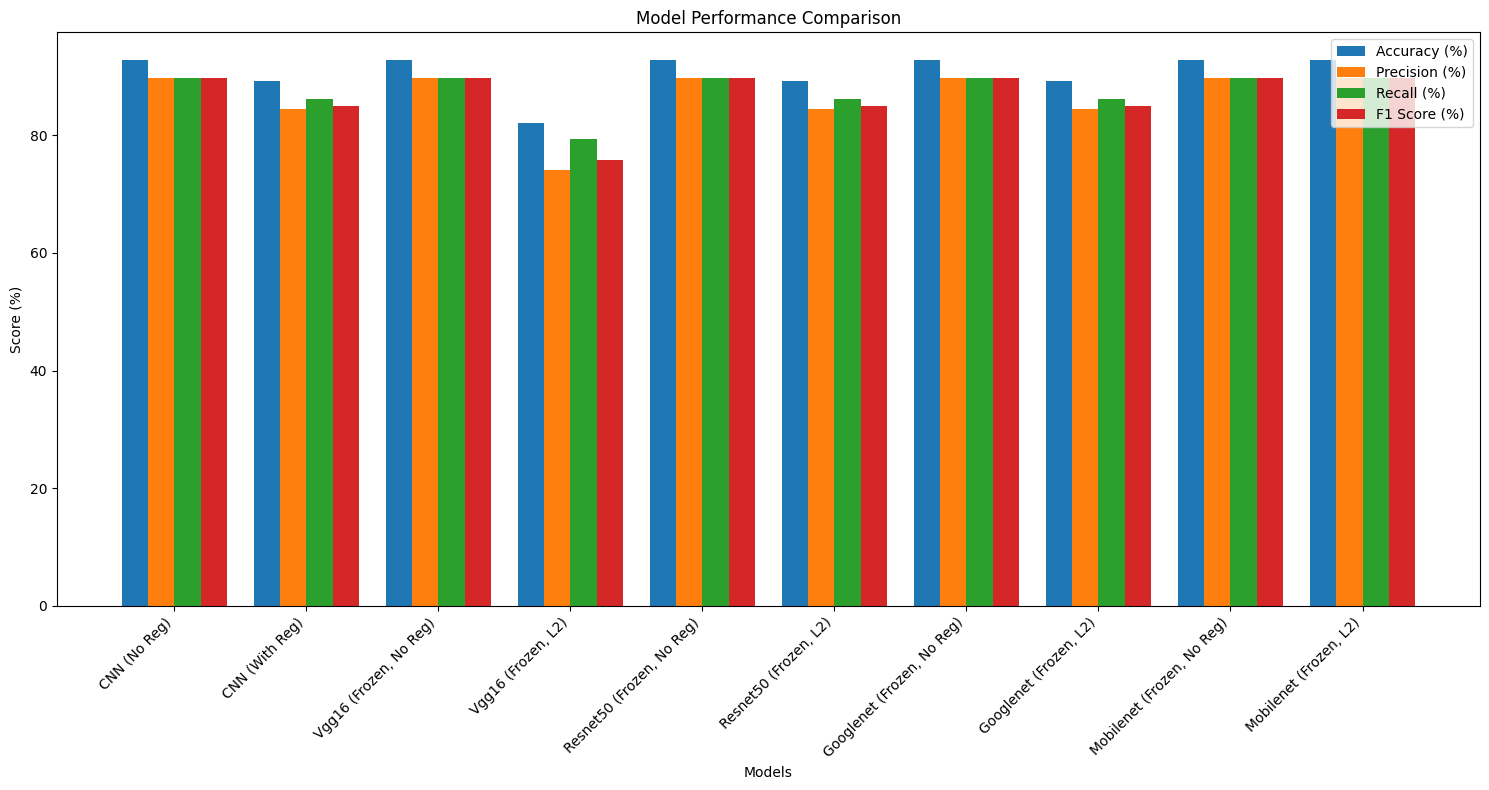

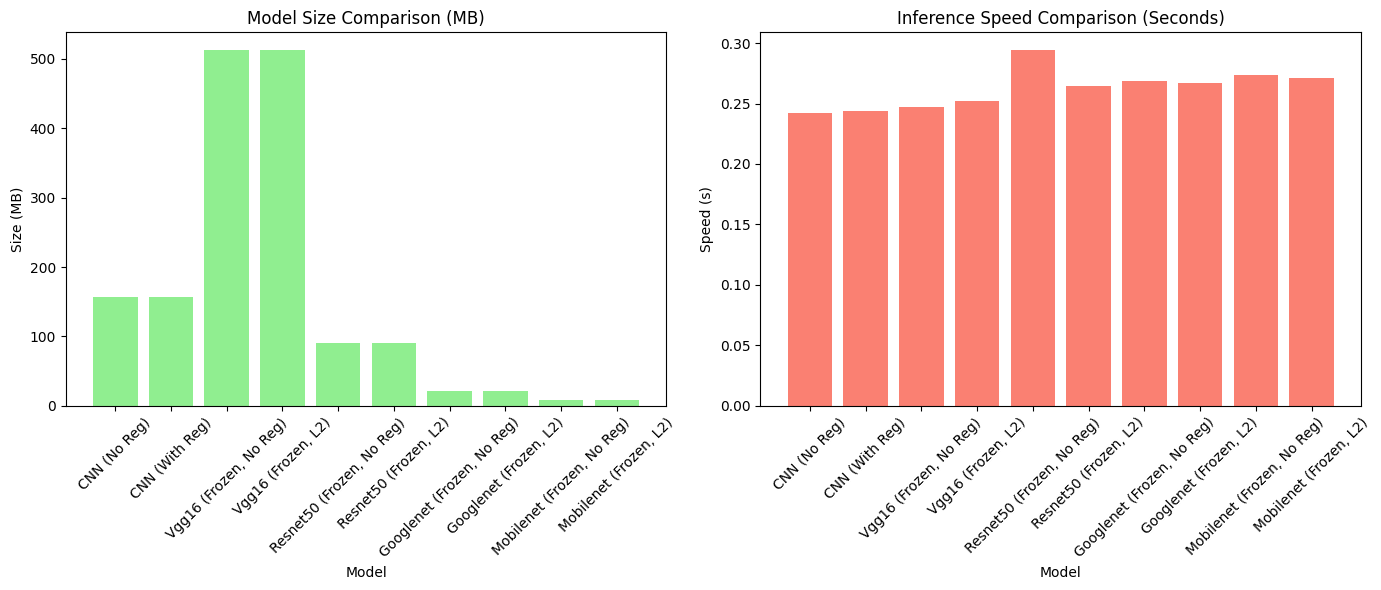


Model Performance Comparison Table:


In [ ]:
data_manager = DatasetManager(
    train_dir=train_dir,
    test_dir=test_dir,
    img_size=200,
    batch_size=32
)
visualizer = ResultsVisualizer()
criterion = nn.CrossEntropyLoss()
def compute_metrics(predictions, labels, target_names):
    report = classification_report(labels, predictions, target_names=target_names, output_dict=True)
    accuracy = report["accuracy"] * 100
    precision = np.mean([report[class_name]["precision"] for class_name in target_names]) * 100
    recall = np.mean([report[class_name]["recall"] for class_name in target_names]) * 100
    f1_score = np.mean([report[class_name]["f1-score"] for class_name in target_names]) * 100
    return accuracy, precision, recall, f1_score
# Evaluating Custom CNN Models
for variation_name, use_reg in [("cnn_no_reg", False), ("cnn_with_reg", True)]:
    print(f"\nEvaluating {variation_name} on Test Dataset")
    cnn_model = SimpleCNN(num_classes=data_manager.num_classes, use_regularization=use_reg).to(device)
    cnn_model.load_state_dict(torch.load(f"{variation_name}_weights.pth"))  # Loading pre-trained weights

    # Measuring Inference Speed and Model Size
    avg_inference_time = measure_inference_speed(cnn_model, data_manager.test_loader, device)
    model_size = get_model_size(cnn_model)

    cnn_trainer = ModelTrainer(cnn_model, device, criterion, None)
    predictions, test_labels = cnn_trainer.predict(data_manager.test_loader)
    accuracy, precision, recall, f1_score = compute_metrics(predictions, test_labels, data_manager.class_names)

    visualizer.add_result(f"CNN ({'No Reg' if not use_reg else 'With Reg'})", accuracy, precision, recall, f1_score, model_size, avg_inference_time)

# Evaluating Pre-trained Models
for model_name in ["vgg16", "resnet50", "googlenet", "mobilenet"]:
    for config_name, freeze, weight_decay in [("frozen_no_reg", True, 0), ("frozen_l2", True, 0.01)]:
        full_name = f"{model_name}_{config_name}"
        print(f"\nEvaluating {full_name} on Test Dataset")

        model = PretrainedModelHandler.get_model(
            model_name=model_name,
            num_classes=data_manager.num_classes,
            freeze_features=freeze
        ).to(device)
        model.load_state_dict(torch.load(f"{full_name}_weights.pth"))

        # Measuring Inference Speed and Model Size
        avg_inference_time = measure_inference_speed(model, data_manager.test_loader, device)
        model_size = get_model_size(model)

        pre_trained_trainer = ModelTrainer(model, device, criterion, None)
        predictions, test_labels = pre_trained_trainer.predict(data_manager.test_loader)
        accuracy, precision, recall, f1_score = compute_metrics(predictions, test_labels, data_manager.class_names)

        model_description = f"{model_name.capitalize()} ({'Frozen' if freeze else 'Full'}, {'No Reg' if weight_decay == 0 else 'L2'})"
        visualizer.add_result(model_description, accuracy, precision, recall, f1_score, model_size, avg_inference_time)

# Plotting and Comparing the Results
visualizer.plot_comparison()

# Generating table
df, final_table = visualizer.generate_table()

# Saving the raw DataFrame as CSV
df.to_csv("model_performance_comparison.csv", index=False)

print("\nModel Performance Comparison Table:")
display(final_table)
